In [1]:
import os
import numpy as np
import pandas as pd

import yfinance as yf
import mplfinance as mpf

from datetime import datetime
from matplotlib import pyplot as plt
from scipy.optimize import Bounds, LinearConstraint, minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

directory_path = './data/'

# Data
We downloaded daily market data for the S&P 500 index from the past two years using the Yahoo Finance API.

In [2]:
ticker = '^GSPC'
interval = '1d'

# sd = datetime(2022, 5, 29)
# ed = datetime(2023, 5, 29)
# df = yf.download(tickers=ticker, start=sd, end=ed, interval=interval)
# df.to_csv(directory_path+'%s_%s_%s_%s.csv'%(ticker,sd.strftime('%Y%m%d'),ed.strftime('%Y%m%d'),interval))

df = pd.DataFrame()
for filename in os.listdir(directory_path):
    if (filename.startswith(ticker)) & (interval in filename):
        df = pd.concat([df, pd.read_csv(directory_path+filename, index_col=0, parse_dates=True)])

df['return'] = (df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
df['sqr_return'] = df['return']**2

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,return,sqr_return
Date,,,,,,,,
2022-05-31,4151.089844,4168.339844,4104.879883,4132.149902,4132.149902,6822640000,NaN,NaN
2022-06-01,4149.779785,4166.540039,4073.850098,4101.229980,4101.229980,4531800000,-0.007483,0.000056
2022-06-02,4095.409912,4177.509766,4074.370117,4176.819824,4176.819824,4405790000,0.018431,0.000340
2022-06-03,4137.569824,4142.669922,4098.669922,4108.540039,4108.540039,3711110000,-0.016347,0.000267
2022-06-06,4134.720215,4168.779785,4109.180176,4121.430176,4121.430176,4332700000,0.003137,0.000010


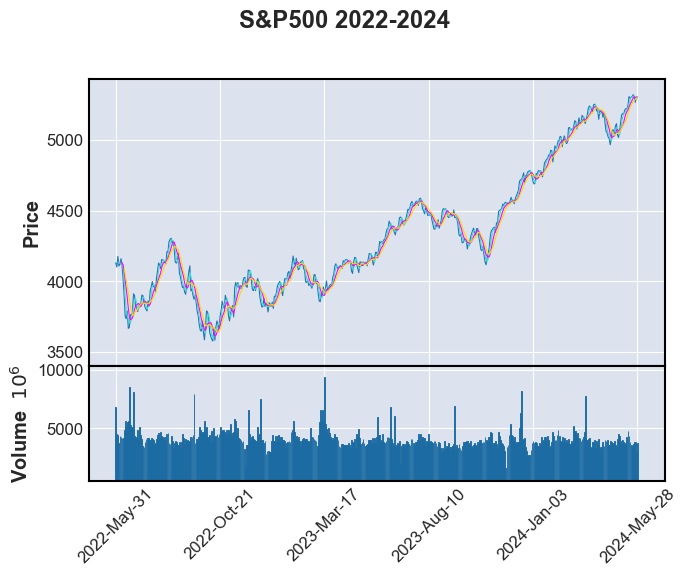

In [4]:
mpf.plot(df,type='line',mav=(3,6,9),volume=True,title='S&P500 2022-2024')

# Models
We proposed two models: an exponentially weighted moving average (EWMA) model and a GARCH(1,1) model. We defined the negative log-likelihood functions for both models. Thus, finding the maximum likelihood estimator is equivalent to minimizing these negative log-likelihood functions.

In [5]:
def ewma_likelihood_fn(v):
    """
    Parameters:
        v (float): The point at which to evaluate the likelihood function. It should lie between 0 and 1, excluding 0.
    Returns:
        float: The value of EWMA model likelihood function at given point.
    """
    # var and likelihood function for index 2 
    var = df['sqr_return'].iloc[1]
    f = np.log(var)+df['sqr_return'].iloc[2]/var
    prev_var = var
    # var and likelihood function for index greater than 2
    for i in range(3, len(df)):
        var = v*prev_var + (1-v)*df['sqr_return'].iloc[i-1]
        f += np.log(var)+df['sqr_return'].iloc[i]/var
        prev_var = var
    return f

Text(0.5, 1.0, 'EWMA Likelihood Function')

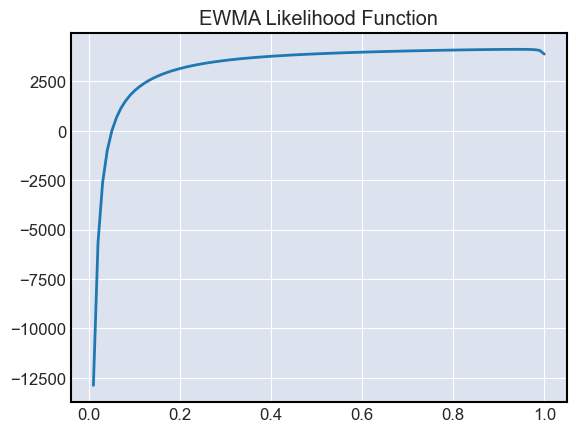

In [6]:
x = np.linspace(0.01,1,99)
y = np.array([-ewma_likelihood_fn(i) for i in x])
plt.plot(x,y)
plt.title('EWMA Likelihood Function')

In [7]:
bounds = Bounds([0],[1])
x0 = np.array([0.5])

ewma_res = minimize(ewma_likelihood_fn, x0, method = 'trust-constr', bounds = bounds)
ewma_res

C:\Users\Hirender\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -4115.645250000757
                 x: [ 9.417e-01]
               nit: 85
              nfev: 110
              njev: 55
              nhev: 0
          cg_niter: 73
      cg_stop_cond: 1
              grad: [ 1.831e-04]
   lagrangian_grad: [ 6.181e-07]
            constr: [array([ 9.417e-01])]
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
                    	with 1 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-1.825e-04])]
            method: tr_interior_point
        optimality: 6.181012228575968e-07
  constr_violation: 0.0
    execution_time: 1.7183897495269775
         tr_radius: 1.0000000000000005e-09
    constr_penalty: 1.0
 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
             

In [8]:
scale_param = [0.00001,1,0.1]

def garch_likelihood_fn(x):
    # var and likelihood function for index 2 
    var = df['sqr_return'].iloc[1]
    f = np.log(var)+df['sqr_return'].iloc[2]/var
    prev_var = var
    # var and likelihood function for index greater than 2
    for i in range(3, len(df)):
        var = np.dot(np.array([x[0],x[1]*prev_var,x[2]*df['sqr_return'].iloc[i-1]]),np.array(scale_param))
        f += np.log(var)+df['sqr_return'].iloc[i]/var
        prev_var = var
    return f

In [9]:
bounds = Bounds([0,0,0],[1,1,1], keep_feasible = True)
linear_constraint = LinearConstraint([[0,1,1]], [0], [1])
x0 = np.array([0.5,0.5,0.5])

garch_res = minimize(garch_likelihood_fn, x0, method='trust-constr', bounds = bounds, constraints = linear_constraint)
garch_res

C:\Users\Hirender\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -4044.018959371978
                 x: [ 1.000e+00  8.888e-01  1.112e-01]
               nit: 111
              nfev: 604
              njev: 151
              nhev: 0
          cg_niter: 125
      cg_stop_cond: 4
              grad: [-9.791e+00 -2.108e+02 -2.108e+02]
   lagrangian_grad: [-3.393e-13  2.203e-06 -2.203e-06]
            constr: [array([ 1.000e+00]), array([ 1.000e+00,  8.888e-01,  1.112e-01])]
               jac: [array([[ 0.000e+00,  1.000e+00,  1.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00],
                           [ 0.000e+00,  0.000e+00,  1.000e+00]])]
       constr_nfev: [0, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([ 2.108e+02]), array([ 9.791e+00, -1.809e-04,  1.809e-04])]
            method: tr_interior_point
        

The following codes prints the values of α + β and sqrt(V_L) in John Hull's book, where V_L is the long-run volatility.

In [10]:
variance_long_run = garch_res.x[0]*scale_param[0]/(1-garch_res.x[1]-garch_res.x[2]*scale_param[2])

print(garch_res.x[1]+garch_res.x[2])
print(np.sqrt(variance_long_run))

0.9999999911075953
0.009995364874573536


After fitting a GARCH(1,1) model, we add the fitted variance to the original dataframe and perform Ljung-Box test.

In [11]:
df['variance'] = np.nan
df.loc[:,'variance'].iat[2] = df.loc[:,'sqr_return'].iat[1]
for i in range(3,len(df)):
    df.loc[:,'variance'].iat[i] = np.dot(garch_res.x, np.array([scale_param[0],df['variance'].iloc[i-1],df['sqr_return'].iloc[i-1]*scale_param[2]]))

In [12]:
df['sqr_return/variance'] = df['sqr_return']/df['variance']

In [13]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,return,sqr_return,variance,sqr_return/variance
Date,,,,,,,,,,
2022-05-31,4151.089844,4168.339844,4104.879883,4132.149902,4132.149902,6822640000,NaN,NaN,NaN,NaN
2022-06-01,4149.779785,4166.540039,4073.850098,4101.229980,4101.229980,4531800000,-0.007483,0.000056,NaN,NaN
2022-06-02,4095.409912,4177.509766,4074.370117,4176.819824,4176.819824,4405790000,0.018431,0.000340,0.000056,6.067000
2022-06-03,4137.569824,4142.669922,4098.669922,4108.540039,4108.540039,3711110000,-0.016347,0.000267,0.000064,4.205591
2022-06-06,4134.720215,4168.779785,4109.180176,4121.430176,4121.430176,4332700000,0.003137,0.000010,0.000069,0.141736


The following graphs show that variance has autocorrelation at lag 15 while this is removed in the autocorrelation for sqr_return/variance.

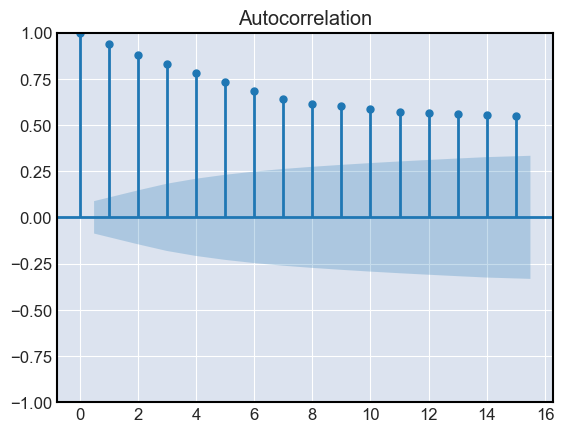

In [14]:
pic_1 = plot_acf(df['variance'].iloc[2:],lags=15)

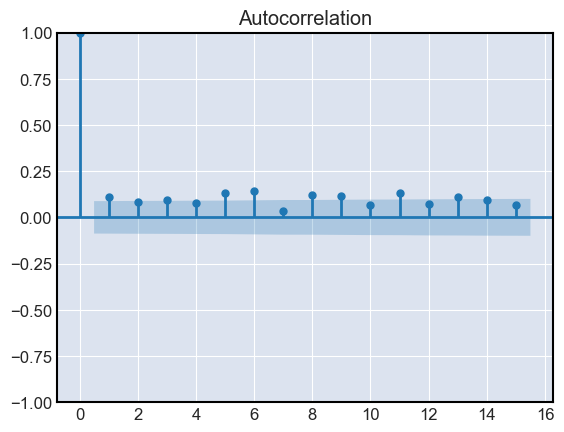

In [15]:
pic_2 = plot_acf(df['sqr_return/variance'].iloc[2:],lags=15)

By the Ljung-Box test, autocorrelation is largely removed for sqr_return/variance as the test statistics is 76.87.

In [16]:
acorr_ljungbox(df['variance'].iloc[2:],lags=[15])

,lb_stat,lb_pvalue
15,3554.245852,0.0


In [17]:
acorr_ljungbox(df['sqr_return/variance'].iloc[2:],lags=[15])

,lb_stat,lb_pvalue
15,76.875333,2.590606e-10


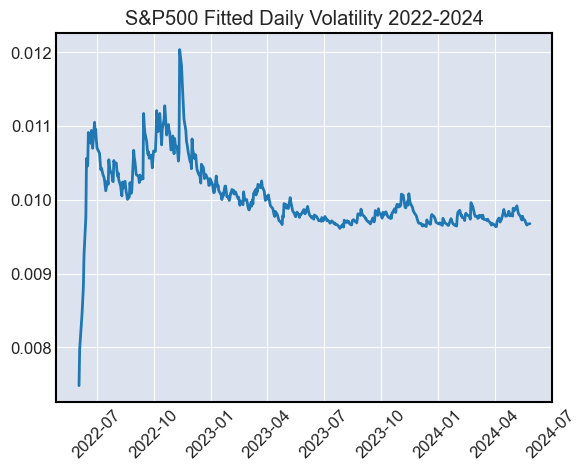

In [18]:
plt.plot(df['variance'].apply(lambda x: np.sqrt(x)))
plt.title('S&P500 Fitted Daily Volatility 2022-2024')
plt.xticks(rotation=45)
plt.show()

# Forecast
Currently volatility is a bit below the long-run volatility 0.0099.

In [19]:
print(np.sqrt(df['variance'].iloc[-1]))

0.00967649237338066


Below is volatility forecast for the next 120 days. The plot shows that it converges to the long-run volatility.

In [20]:
forecasts = [(garch_res.x[1]+garch_res.x[2])*(df['variance'].iloc[-1]-variance_long_run)]
for _ in range(120):
    forecasts.append(forecasts[-1]*(garch_res.x[1]+garch_res.x[2]*scale_param[2]))
forecasts += variance_long_run
forecasts = pd.Series(forecasts)

Text(0.5, 1.0, 'Volatility Forecast for Next 120 Days')

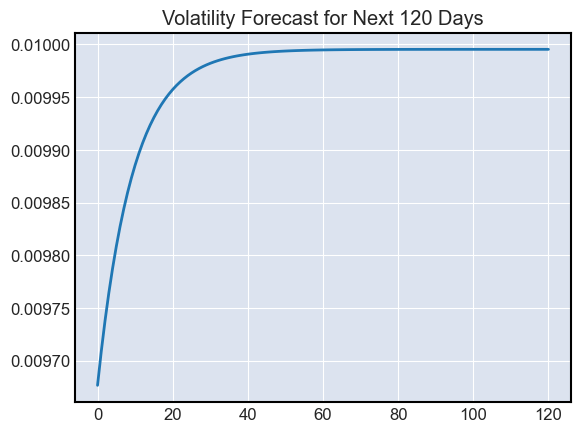

In [21]:
plt.plot(np.sqrt(forecasts))
plt.title('Volatility Forecast for Next 120 Days')

# Reference
1. Hull, J. C. (2022). Options, futures, and other derivatives.